In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scipy
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions

In [2]:
def p_regplot(x,y,dataset):
    ax=sns.regplot(x=x,y=y, data=dataset, line_kws={"color": "orange"})
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
    x=ax.get_lines()[0].get_xdata(),
    y=ax.get_lines()[0].get_ydata())
    print("\n       slope=",slope, "    ","intercept=",intercept)
    print("                                      ","r_value=",r_value, "p_value=",p_value, "std_err=",std_err)
   

In [3]:
gal_df = pd.read_csv("Data/galaxies_near_clusters_0.3-0.6.csv") 
cluster_data = pd.read_csv("Data/cluster_data_0.3-0.6.csv")

## Modeling the data set

Oct 7, 20021

### Linear fit

Although for now this code is unnecessarily complicated, it is equivalent to linear regression: I defined a model with only a single perceptron tf.keras.layers.Dense(1), which by default has a linear activation function and can take bias into account (that is, for x=0 the model will not necessarily predict y=0).

In [4]:
x=cluster_data["stellarmass"]; y=cluster_data["halo_mass"];

In [5]:
model = tf.keras.Sequential([    tf.keras.layers.Dense(1)  ])

model.compile(optimizer=tf.optimizers.Adam(learning_rate = 0.1), loss='mean_squared_error')

history=model.fit(x, y, epochs=40);

2021-10-07 19:38:58.539622: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-07 19:38:58.539935: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-07 19:38:58.543986: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 32. Tune using inter_op_parallelism_threads for best performance.
2021-10-07 19:38:58.604656: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-07 19:38:58.605225: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2300090000 Hz


Epoch 1/40
9/9 [==============================] - 1s 1ms/step - loss: 1.6000
Epoch 2/40
9/9 [==============================] - 0s 1ms/step - loss: 0.4653
Epoch 3/40
9/9 [==============================] - 0s 961us/step - loss: 0.1791
Epoch 4/40
9/9 [==============================] - 0s 887us/step - loss: 0.0726
Epoch 5/40
9/9 [==============================] - 0s 1ms/step - loss: 0.0602
Epoch 6/40
9/9 [==============================] - 0s 2ms/step - loss: 0.0367
Epoch 7/40
9/9 [==============================] - 0s 1ms/step - loss: 0.0354
Epoch 8/40
9/9 [==============================] - 0s 2ms/step - loss: 0.0286
Epoch 9/40
9/9 [==============================] - 0s 1ms/step - loss: 0.0358
Epoch 10/40
9/9 [==============================] - 0s 2ms/step - loss: 0.0320
Epoch 11/40
9/9 [==============================] - 0s 1ms/step - loss: 0.0287
Epoch 12/40
9/9 [==============================] - 0s 1ms/step - loss: 0.0312
Epoch 13/40
9/9 [==============================] - 0s 1ms/step - loss

In [6]:
model.summary()
y_fit = model.predict(x)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [7]:
np.shape(x), y.shape, y_fit.shape
y_fit=y_fit[:,0]
#y_fit.shape

<AxesSubplot:xlabel='stellarmass', ylabel='halo_mass'>

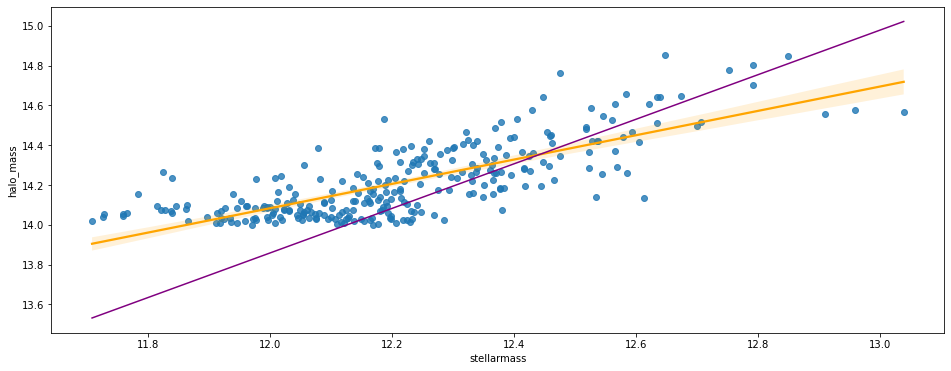

In [8]:
ds = pd.DataFrame((x,y, y_fit), columns=['x', 'y', 'y_fit'])
plt.figure(figsize=(16, 6))
#p_regplot("x","y",ds)
sns.regplot(x="stellarmass",y="halo_mass", data=cluster_data, line_kws={"color": "orange"})
sns.lineplot(x=x,y=y_fit, color="purple")

dict_keys(['loss'])


Text(0.5, 0, 'epoch')

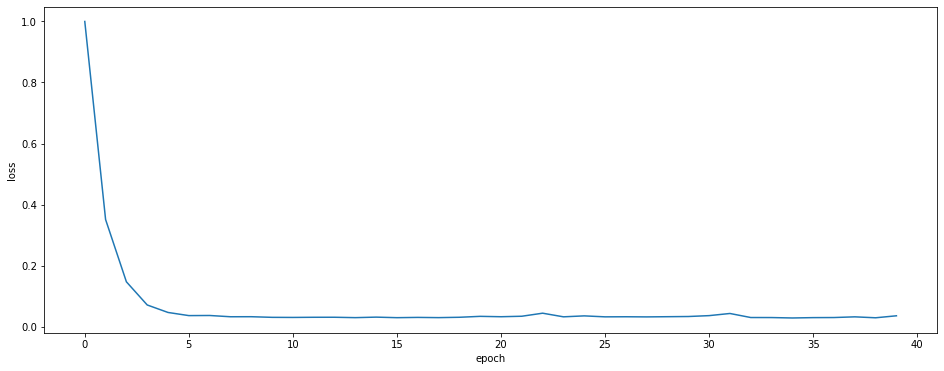

In [9]:
# list all data in history
print(history.history.keys())
# summarize history for loss

#plt.legend(['train', 'test'], loc='upper left')
plt.figure(figsize=(16, 6))
sns.lineplot(x=np.arange(0,len(history.history['loss'])),y=history.history['loss'])
#sns.lineplot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

### normal distributions

Let’s try now to make the model output not just a number, but a distribution; for the sake of definiteness, let’s try to learn the “best” normal distribution which models the random variable 
Y
 for each value of 
X
. In order to do so, notice that we cannot use anymore the mean squared error as a loss function, since it is not a meaningful error metric in this case. We will, instead, use the negative logarithm of likelihood between the distributions given by our model vs the observed data; in this way, training our model becomes essentially a maximum likelihood estimation of parameters!

**Notice also that for each value of 
X
 the normal distribution we want our model to learn is parametrized by two numbers: mean and standard deviation.** Therefore, we should increase the number of neurons in the dense layer from one to two, so that each perceptron will learn the functional dependency on 
X
 of one of the two parameters, and then push its output into the distribution.

The way to implement these changes in TensorFlow Probability is very nice: we can use a tfp.layers.DistributionLambda layer which works in pretty much the same way as a “standard” Keras layer; in its argument, we can plug a lambda function which takes parameters from the previous layers of the network and returns a tfp.Distribution:

In [12]:
model = tf.keras.Sequential([
            tf.keras.layers.Dense(2),
            tfp.layers.DistributionLambda(lambda t:
                tfp.distributions.LogNormal(
                    loc   = t[...,:1],
                    scale = tf.math.softplus(0.005*t[...,1:])+0.001),
                    name='LogNormal'
                )
])

negloglik = lambda y, p_y: -p_y.log_prob(y)

model.compile(optimizer=tf.optimizers.Adam(learning_rate = 0.1),
              loss=negloglik)            
#             loss='mean_squared_error')

2021-10-07 19:39:50.882630: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 1/40
9/9 [==============================] - 1s 2ms/step - loss: 114.7429
Epoch 2/40
9/9 [==============================] - 0s 2ms/step - loss: 5.9453
Epoch 3/40
9/9 [==============================] - 0s 2ms/step - loss: 14.6245
Epoch 4/40
9/9 [==============================] - 0s 1ms/step - loss: 4.0256
Epoch 5/40
9/9 [==============================] - 0s 1ms/step - loss: 4.8040
Epoch 6/40
9/9 [==============================] - 0s 2ms/step - loss: 3.4352
Epoch 7/40
9/9 [==============================] - 0s 1ms/step - loss: 3.4801
Epoch 8/40
9/9 [==============================] - 0s 2ms/step - loss: 3.2556
Epoch 9/40
9/9 [==============================] - 0s 1ms/step - loss: 3.2746
Epoch 10/40
9/9 [==============================] - 0s 6ms/step - loss: 3.2316
Epoch 11/40
9/9 [==============================] - 0s 1ms/step - loss: 3.2364
Epoch 12/40
9/9 [==============================] - 0s 1ms/step - loss: 3.2281
Epoch 13/40
9/9 [==============================] - 0s 1ms/step - loss:

Text(0.5, 0, 'epoch')

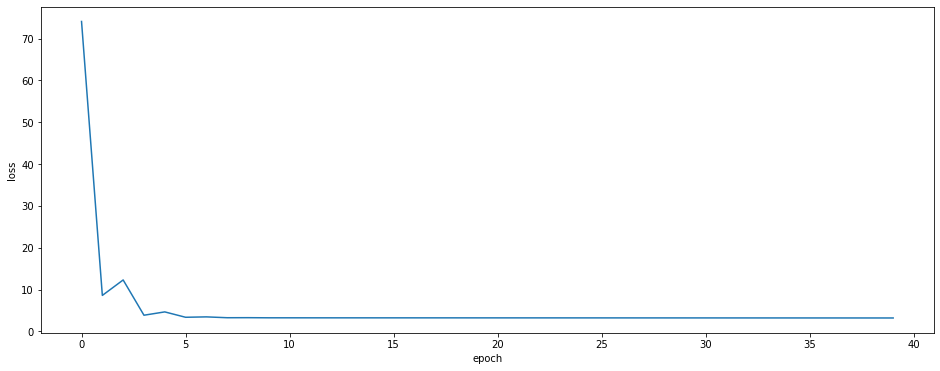

In [13]:
history=model.fit(x, y, epochs=40);
print(history)
# list all data in history
print(history.history.keys())
# summarize history for loss

#plt.legend(['train', 'test'], loc='upper left')
plt.figure(figsize=(16, 6))
sns.lineplot(x=np.arange(0,len(history.history['loss'])),y=history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 2)                 4         
_________________________________________________________________
LogNormal (DistributionLambd multiple                  0         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________
[ 0.14038308 -0.4598733 ]
[0.93820304 0.8217858 ]
18.163002 13.980062


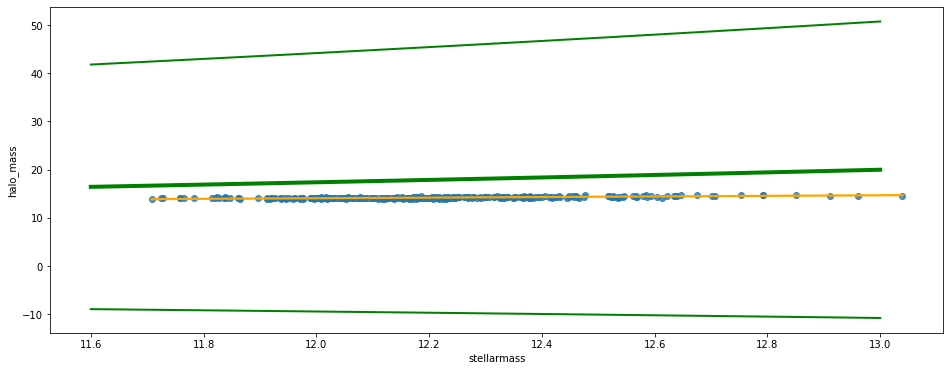

In [14]:
model.summary()
y_fit = model.predict(x)
y_fit=y_fit[:,0]
ds = pd.DataFrame((x,y, y_fit), columns=['x', 'y', 'y_fit'])
plt.figure(figsize=(16, 6))
#p_regplot("x","y",ds)
sns.regplot(x="stellarmass",y="halo_mass", data=cluster_data, line_kws={"color": "orange"})

xf=np.arange(11.6,13,0.1)
xf=xf[:,None]
yhat=model(xf)
m = yhat.mean()
s = yhat.stddev()

plt.plot(xf, m, 'g', linewidth=4, label='mean');
plt.plot(xf, m + 2 * s, 'g', linewidth=2, label=r'mean + 2 stddev');
plt.plot(xf, m - 2 * s, 'g', linewidth=2, label=r'mean - 2 stddev');
[print(np.squeeze(w.numpy())) for w in model.weights];
print(np.mean(m),np.mean(s))

## Regression

Let's follow the TF-P tutorial on regressions: https://www.tensorflow.org/probability/examples/Probabilistic_Layers_Regression

### Case 1: No Uncertainty

In [15]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

In [60]:
# Build model.
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1),
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)), 
])


# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False);

# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];


0.9966387
2.0662038


In [61]:
x_tst=np.arange(11.6,13,0.1)
x_tst=x_tst[:,None]
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

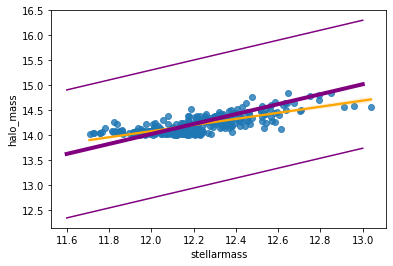

In [62]:
sns.regplot(x="stellarmass",y="halo_mass", data=cluster_data, line_kws={"color": "orange"})
#sns.lineplot(x=xf,y=yhat[:,0], color="purple")
plt.plot(x_tst, yhat.mean(),'purple', label='mean', linewidth=4);
plt.plot(x_tst, yhat.quantile(0.32),'purple');
plt.plot(x_tst, yhat.quantile(0.68),'purple');

In [63]:
#yhat.mean(), yhat.quantile(.1), yhat.quantile(0.9)
#yhat.stddev(),model.summary(),
#z=yhat.sample(100)
#np.shape(z)
#dir(yhat)

## Case 2: Aleatoric Uncertainty

In [89]:
# Build model.
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1 + 1),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.05 * t[...,1:]))),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False);

# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

[ 0.9459306 -1.9238751]
[ 2.680965  -1.0970588]


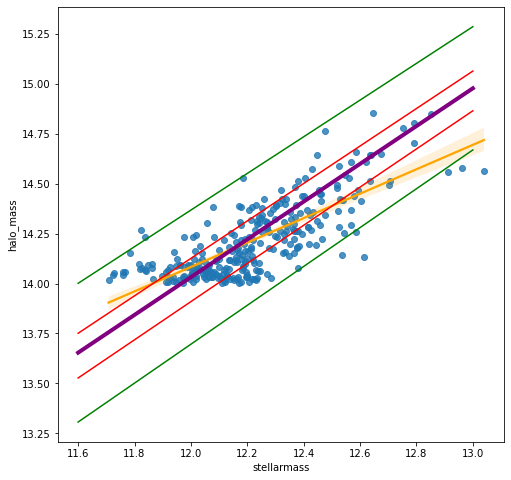

In [91]:
fig, ax = plt.subplots(1,1, figsize=(8, 8))
sns.regplot(x="stellarmass",y="halo_mass", data=cluster_data, line_kws={"color": "orange"})
#sns.lineplot(x=xf,y=yhat[:,0], color="purple")
plt.plot(x_tst, yhat.mean(),'purple', label='mean', linewidth=4);
plt.plot(x_tst, yhat.quantile(0.1),'green');
plt.plot(x_tst, yhat.quantile(0.9),'green');
plt.plot(x_tst, yhat.quantile(0.32),'r');
plt.plot(x_tst, yhat.quantile(0.68),'r');

## Case 3: Epistemic Uncertainty

In [95]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

In [96]:
# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])

In [97]:
# Build model.
model = tf.keras.Sequential([
  tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable, kl_weight=1/x.shape[0]),
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False);

# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

[ 1.0605583  1.3262157 -5.090317  -3.347929 ]
[1.0404091 1.3087453]


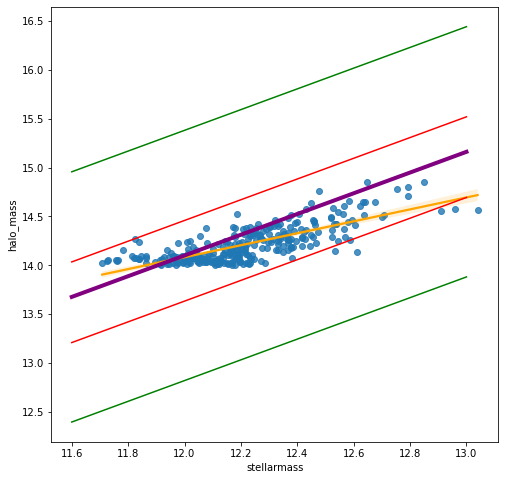

In [98]:
fig, ax = plt.subplots(1,1, figsize=(8, 8))
sns.regplot(x="stellarmass",y="halo_mass", data=cluster_data, line_kws={"color": "orange"})
#sns.lineplot(x=xf,y=yhat[:,0], color="purple")
plt.plot(x_tst, yhat.mean(),'purple', label='mean', linewidth=4);
plt.plot(x_tst, yhat.quantile(0.1),'green');
plt.plot(x_tst, yhat.quantile(0.9),'green');
plt.plot(x_tst, yhat.quantile(0.32),'r');
plt.plot(x_tst, yhat.quantile(0.68),'r');

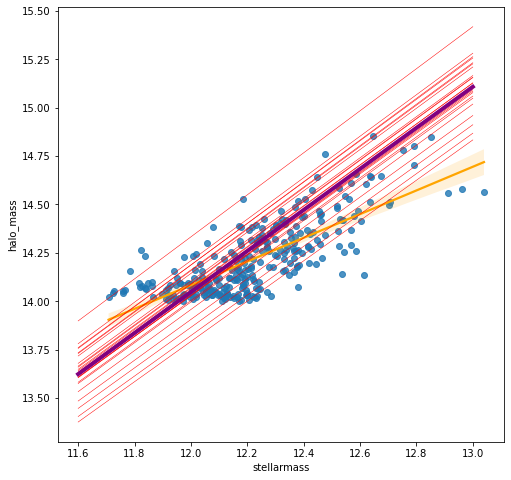

In [102]:
fig, ax = plt.subplots(1,1, figsize=(8, 8))
sns.regplot(x="stellarmass",y="halo_mass", data=cluster_data, line_kws={"color": "orange"})
yhats = [model(x_tst) for _ in range(100)]
avgm = np.zeros_like(x_tst[..., 0])
for i, yhat in enumerate(yhats):
  m = np.squeeze(yhat.mean())
  #s = np.squeeze(yhat.stddev())
  if i < 25:
    plt.plot(x_tst, m, 'r', label='ensemble means' if i == 0 else None, linewidth=0.5)
  avgm += m
plt.plot(x_tst, avgm/len(yhats), 'purple', label='overall mean', linewidth=4)

## Case 4: Aleatoric & Epistemic Uncertainty

In [130]:
# Build model.
model = tf.keras.Sequential([
  tfp.layers.DenseVariational(1 + 1, posterior_mean_field, prior_trainable, kl_weight=1/x.shape[0]),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.01 * t[...,1:]))),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False);

# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

[ 1.0511039  -2.96433085  1.3047126  -2.5525634  -5.10029362 -0.37625678
 -3.65529608  0.04121314]
[ 1.0541997  -2.72067463  1.32338976 -2.36581441]


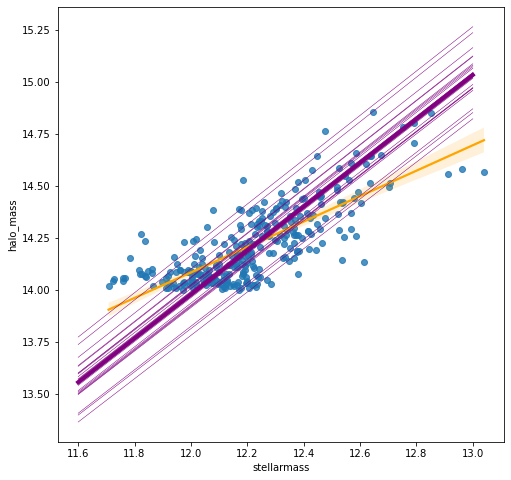

In [104]:
fig, ax = plt.subplots(1,1, figsize=(8, 8))
sns.regplot(x="stellarmass",y="halo_mass", data=cluster_data, line_kws={"color": "orange"})
yhats = [model(x_tst) for _ in range(100)]
avgm = np.zeros_like(x_tst[..., 0])
for i, yhat in enumerate(yhats):
  m = np.squeeze(yhat.mean())
  s = np.squeeze(yhat.stddev())
  if i < 25:
    plt.plot(x_tst, m, 'purple', label='ensemble means' if i == 0 else None, linewidth=0.5)
  avgm += m
plt.plot(x_tst, avgm/len(yhats), 'purple', label='overall mean', linewidth=4)

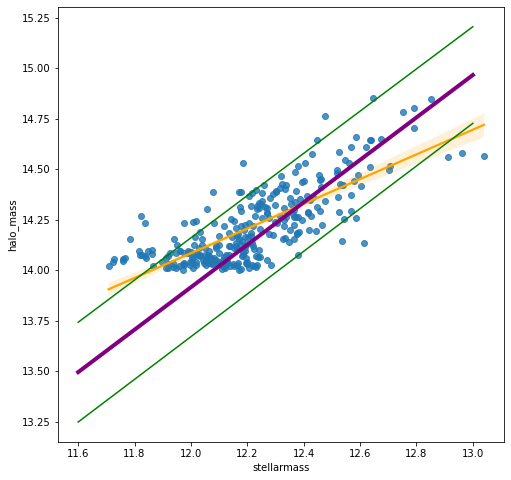

In [134]:
fig, ax = plt.subplots(1,1, figsize=(8, 8))
sns.regplot(x="stellarmass",y="halo_mass", data=cluster_data, line_kws={"color": "orange"})
yhats = [model(x_tst) for _ in range(10000)]
avgm = np.zeros_like(x_tst[..., 0])
s1m = np.zeros_like(x_tst[..., 0])
s2m = np.zeros_like(x_tst[..., 0])
for i, yhat in enumerate(yhats):
  m = np.squeeze(yhat.mean())
  s1 = np.squeeze(yhat.quantile(0.32))
  s2 = np.squeeze(yhat.quantile(0.68))
#  if i < 15:
#    plt.plot(x_tst, m, 'r', label='ensemble means' if i == 0 else None, linewidth=1.)
#    plt.plot(x_tst, s2, 'g', linewidth=0.5, label='ensemble means + 1 ensemble stdev' if i == 0 else None);
#    plt.plot(x_tst, s1, 'g', linewidth=0.5, label='ensemble means - 1 ensemble stdev' if i == 0 else None);
  avgm += m
  s1m += s1
  s2m += s2
plt.plot(x_tst, avgm/len(yhats), 'purple', label='overall mean', linewidth=4)
plt.plot(x_tst, s1m/len(yhats), 'g')
plt.plot(x_tst, s2m/len(yhats), 'g')

## Case 5: Functional Uncertainty

Custom PSD Kernel

In [128]:
class RBFKernelFn(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super(RBFKernelFn, self).__init__(**kwargs)
    dtype = kwargs.get('dtype', None)

    self._amplitude = self.add_variable(
            initializer=tf.constant_initializer(0),
            dtype=dtype,
            name='amplitude')

    self._length_scale = self.add_variable(
            initializer=tf.constant_initializer(0),
            dtype=dtype,
            name='length_scale')

  def call(self, x):
    # Never called -- this is just a layer so it can hold variables
    # in a way Keras understands.
    return x

  @property
  def kernel(self):
    return tfp.math.psd_kernels.ExponentiatedQuadratic(
      amplitude=tf.nn.softplus(0.1 * self._amplitude),
      length_scale=tf.nn.softplus(5. * self._length_scale)
    )


In [129]:
# For numeric stability, set the default floating-point dtype to float64
tf.keras.backend.set_floatx('float64')


# Build model.
num_inducing_points = 40
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[1]),
    tf.keras.layers.Dense(1, kernel_initializer='ones', use_bias=False),
    tfp.layers.VariationalGaussianProcess(
        num_inducing_points=num_inducing_points,
        kernel_provider=RBFKernelFn(),
        event_shape=[1],
        inducing_index_points_initializer=tf.constant_initializer(
            np.linspace(x_tst[0],x_tst[-1], num=num_inducing_points,
                        dtype=x.dtype)[..., np.newaxis]),
        unconstrained_observation_noise_variance_initializer=(
            tf.constant_initializer(np.array(0.54).astype(x.dtype))),
    ),
])



/global/homes/a/annis/.conda/envs/tflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


AttributeError: 'NoneType' object has no attribute 'as_numpy_dtype'

In [126]:
# Do inference.
batch_size = 32
loss = lambda y, rv_y: rv_y.variational_loss(
    y, kl_weight=np.array(batch_size, x.dtype) / x.shape[0])
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=loss)
model.fit(x, y, batch_size=batch_size, epochs=1000, verbose=False)

# Profit.
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


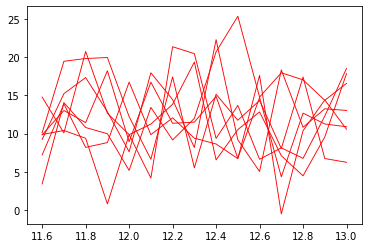

In [127]:
num_samples = 7
for i in range(num_samples):
  sample_ = yhat.sample().numpy()
  plt.plot(x_tst,
           sample_[..., 0].T,
           'r',
           linewidth=0.9,
           label='ensemble means' if i == 0 else None);